# Exercise 1 b
## 3 Nearest Neighbor Classification on Real Data
### 3.1 Exploring the Data

In [6]:
#load dataset from sklearn
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

print(data.dtype)

#check, what is the size of the images
print(images[0].shape)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64
(8, 8)


As we can see the size of the images is 8x8.

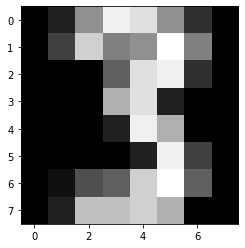

In [22]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

img = images[13]

assert (2 == len(img.shape)), "img does not have a valid shape"

plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()

We plotted some of the images and found out that for example the 13th image is a 3.

In [25]:
#Split the data into a training and a test set
from sklearn import model_selection

X_all = data
y_all = target

X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(digits.data, digits.target, 
                                    test_size = 0.4, random_state = 0)

### 3.2 Distance function computation using loops

In [145]:
#define euclidian distance function using loops
def dist_loop(training, test):
    #test if the inputs are NxD, MxD matrices
    assert (2 == len(np.shape(training))), "training does not have a valid shape."
    assert (2 == len(np.shape(test))), "training does not have a valid shape."
    assert (np.shape(test)[1] == np.shape(training)[1]), "training and test do not have compatible shapes."
    
    #introduce MxN array for the output
    N = np.shape(training)[0]
    M = np.shape(test)[0]
    D = np.shape(training)[1]
    distances = np.zeros(shape=(N,M))
    
    #convert the input to numpy arrays
    training = np.array(training)
    test = np.array(test)
    
    #compute the euclidian distance for every combination of one row from 
    #training and test each
    for i in range(N):
        for j in range(M):
            distances[i][j] = np.linalg.norm(training[i]-test[j])
            
    return distances

### 3.3 Distance function computation using vectorization

In [171]:
def dist_vec(training, test):
    #test if the inputs are NxD, MxD matrices
    assert (2 == len(np.shape(training))), "training does not have a valid shape."
    assert (2 == len(np.shape(test))), "training does not have a valid shape."
    assert (np.shape(test)[1] == np.shape(training)[1]), "training and test do not have compatible shapes."   
    
    #convert trianing and test to numpy arrays
    training = np.array(training)
    test = np.array(test)
    
    distances = np.linalg.norm(training[:, np.newaxis]-test, axis=2)

    return distances

In [172]:
#test if the results of dist_loop and dist_vec are the same
x = np.array([[1,2],[3,4]])
y  = np.array([[5,6],[7,8],[9,10]])

z = dist_vec(x,y)
print(z)

z = dist_loop(x,y)
print(z)

#test which method needs longer
x = np.ones(shape=(1000,3))
y = 2 * np.ones(shape=(1000,3))

%timeit dist_vec(x,y)
%timeit dist_loop(x,y)

[[ 5.65685425  8.48528137 11.3137085 ]
 [ 2.82842712  5.65685425  8.48528137]]
[[ 5.65685425  8.48528137 11.3137085 ]
 [ 2.82842712  5.65685425  8.48528137]]
38.5 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.35 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see that both functions deliver the same results, but with N = M = 1000 the vectorized function is two orders of magnitude faster.